In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import logging
logging.root.setLevel(10)
import seaborn as sns; sns.set_theme()

import sys
import json
import os
sys.path.insert(0, os.path.realpath('..'))
os.chdir('..')

from src import data
from src.model import get_splits
with open('config.json', 'r') as cfg:
    config = json.load(cfg)
    
random_seed = 42

In [2]:
#!pip install tueplots
from tueplots import bundles
# global change:
plt.rcParams.update(bundles.neurips2021(usetex=False))

In [3]:
def get_country_name(code):
    country = pycountry.countries.get(alpha_3=code)
    return country.name if country else None


def load_data(config, get_top_level_categories=False):
    return_columns = [
        "Country code", "Country", "Function code", "Function", "Year",
        'Percentage of total expenditure', 'Total expenditure per capita (1000s USD)',
        'Expenditure per capita (1000s USD)', 'Happiness score',
    ]
    data_path = config["data_location"]
    cofog = pd.read_csv(data_path + config["cofog_dataset"])
    happiness = pd.read_csv(data_path + config["happiness_dataset"], sep=';')
    total_spending = pd.read_csv(data_path + config["total_spending_dataset"])

    # Normalize OECD data to percentages of total instead of millions

    cofog.rename(columns={
        "LOCATION": "Country code",
        "ACTIVITY": "Function code"
    }, inplace=True)
    if get_top_level_categories:
        cofog = cofog[cofog["Function code"].str.len() == 3]
    else:
        cofog = cofog[cofog["Function code"].str.len() > 3]

    # Clean-up - null negative expenditures before, which don't make sense, before summing
    cofog.loc[cofog['Value'] < 0, 'Value'] = 0
    totals = cofog.groupby(["Country", "Year"], as_index=False)["Value"].sum()

    cofog = pd.merge(cofog, totals, on=["Country", "Year"])
    cofog = cofog.rename(columns={"Value_x": "Value", "Value_y": "Total expenditure"})
    cofog["Percentage of total expenditure"] = cofog["Value"]/cofog["Total expenditure"]

    # Calculate expenditure per capita in 1000s of USD
    total_spending["Country"] = total_spending["LOCATION"].apply(get_country_name)
    total_spending = total_spending.rename(columns={"TIME": "Year"})
    cofog_merged = pd.merge(cofog, total_spending[["Country", "Year", "Value"]], on=["Country", "Year"])
    cofog_merged = cofog_merged.rename(columns={"Value_y": "Total expenditure per capita (1000s USD)"})
    cofog_merged["Expenditure per capita (1000s USD)"] = \
        cofog_merged["Percentage of total expenditure"]*cofog_merged["Total expenditure per capita (1000s USD)"]

    # Merge in happiness scores
    happiness = happiness.rename(columns={"Country name": "Country", "year": "Year", "Life Ladder": "Happiness score"})
    happiness["Happiness score"] = pd.to_numeric(happiness["Happiness score"].str.replace(',', '.'))
    return pd.merge(cofog_merged, happiness, on=["Country", "Year"])[return_columns]


def filter_bad_data(data):
    essential_columns = ["Year", "Total expenditure per capita (1000s USD)", "Happiness score"]
    non_negative_columns = ['Percentage of total expenditure', 'Expenditure per capita (1000s USD)']

    data_rows_cnt = len(data.index)
    data.dropna(inplace=True)
    logging.info("Dropped {n} rows with NaN values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data != "").any(axis=1)]
    logging.info("Dropped {n} rows with empty string values".format(n=data_rows_cnt - len(data.index)))
    data_rows_cnt = len(data.index)

    data = data[(data[essential_columns] > 0).any(axis=1)]
    logging.info("Dropped {n} rows with invalid essential columns".format(n=data_rows_cnt - len(data.index)))

    assert not data.isnull().any().any()
    assert not (data == "").any().any()
    assert not (data[essential_columns] <= 0).any().any()
    return data


def create_samples(data):
    """Transforms data into samples with expenditures for each function as a column

    Return a tuple - first element has 'Percentage of total expenditure' as features values, second has
    'Expenditure per capita (1000s USD).'"""
    def make_samples(value_column):
        # Make Function Code values into columns
        pivoted = data.pivot(index=['Country', 'Year'], columns=['Function code'], values=[value_column])

        # Clean up structure
        pivoted.columns = pivoted.columns.get_level_values(1)
        pivoted = pivoted.reset_index()
        pivoted.columns.name = None

        # Missing Country, Year, Function code combinations get nulled
        pivoted = pivoted.where(~pivoted.isnull(), 0)

        return pd.merge(pivoted, data[
            ['Country', 'Year', 'Total expenditure per capita (1000s USD)', 'Happiness score']
        ].drop_duplicates(), on=['Country', 'Year'])

    return make_samples('Percentage of total expenditure'), make_samples('Expenditure per capita (1000s USD)')




In [4]:
whole_data = load_data(config)
whole_data = filter_bad_data(whole_data)
print(whole_data)

INFO:root:Dropped 0 rows with NaN values
INFO:root:Dropped 0 rows with empty string values
INFO:root:Dropped 0 rows with invalid essential columns


      Country code    Country Function code  \
0              AUT    Austria          0101   
1              AUT    Austria          0201   
2              AUT    Austria          0301   
3              AUT    Austria          0401   
4              AUT    Austria          0501   
...            ...        ...           ...   
22106          AUS  Australia          0408   
22107          AUS  Australia          0908   
22108          AUS  Australia          1008   
22109          AUS  Australia          0409   
22110          AUS  Australia          1009   

                                                Function  Year  \
0      Executive and legislative organs, financial, f...  2008   
1                                       Military defence  2008   
2                                        Police services  2008   
3        General economic, commercial and labour affairs  2008   
4                                       Waste management  2008   
...                                    

DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000003.ss000004.ax000005, (left: 0.000) (bot: 0.000) (right: 0.000) (top: 0.000)
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Permic' (NotoSansOldPermic-Regular.ttf) n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Warang Citi' (NotoSansWarangCiti-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahla

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple SD Gothic Neo' (AppleSDGothicNeo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Wancho' (NotoSansWancho-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Multani' (NotoSansMultani-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Takri' (NotoSansTakri-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Futura' (Futura.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Permic' (NotoSansOldPermic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 11.05
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Warang Citi' (NotoSansWarangCiti-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Reg

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (K

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Wancho' (NotoSansWancho-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Multani' (NotoSansMultani-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=italic:variant=normal:weight=normal:stretch=norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Permic' (NotoSansOldPermic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Warang Citi' (NotoSansWarangCiti-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarend

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times'

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.3

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Multani' (NotoSansMultani-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN'

DEBUG:matplotlib.font_manager:findfont: score(<Font 'American Typewriter' (AmericanTypewriter.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=9.0 to STIXGeneral ('/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIX

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Permic' (NotoSansOldPermic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Warang Citi' (NotoSansWarangCiti-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bask

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=9.0 to STIXNonUnicode ('/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=normal:size=9.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Permic' (NotoSansOldPermic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 11.05

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bassa Vah' (Noto

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Psalter Pahlavi' (NotoSansPsalterPahlavi-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 11.2

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=italic:variant=normal:weight=normal:stretch=normal:size=9.0 to STIXNonUnicode ('/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=bold:stretch=normal:size=9.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Obliqu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Duployan' (NotoSansDuployan-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada Sangam MN' (Kannada Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.335
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal 300 normal>) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Nile' (Al Nile.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_mana

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal 900 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=bold:stretch=normal:size=9.0 to STIXNonUnicode ('/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=9.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal 400 n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao MN' (Lao MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG:mat

DEBUG:matplotlib.font_manager:findfont: Matching STIXSizeTwoSym:style=normal:variant=normal:weight=normal:stretch=normal:size=9.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Party LET' (PartyLET-plain.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotli

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Bold.ttf) normal normal 700 normal>

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Ahom' (NotoSerifAhom-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Batak' (NotoSa

DEBUG:matplotlib.font_manager:findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Elbasan' (NotoSansElbasan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matpl

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+

DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplotlib.ticker:ticklocs array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
DEBUG:matplotlib.ticker:vmin 3500.1276090942397 vmax 58012.89811309078
DEBUG:matplot

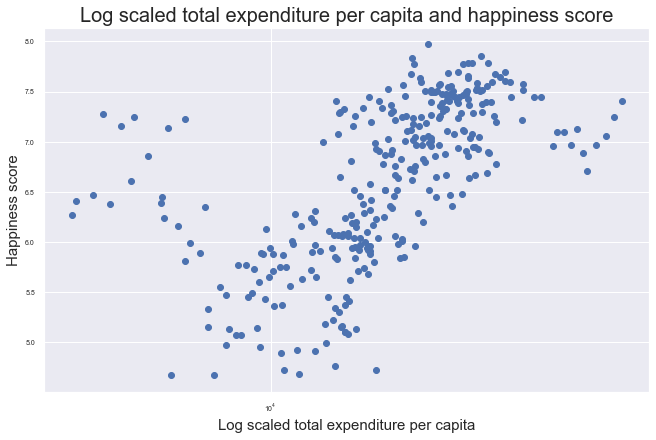

In [6]:
#scatter plot of total expenditure per capita and happiness score
unique_total_exp = whole_data.groupby(['Country code', 'Year'])["Total expenditure per capita (1000s USD)"].mean()
unique_happiness_index = whole_data.groupby(['Country code', 'Year'])["Happiness score"].mean()

#log scaled scatter plot of total expenditure per capita and happiness score
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(unique_total_exp, unique_happiness_index)
ax.set_xscale("log")
ax.set_xlabel("Log scaled total expenditure per capita", fontsize = 15)
ax.set_ylabel("Happiness score", fontsize = 15)
ax.set_title("Log scaled total expenditure per capita and happiness score", fontsize = 20)

plt.show()